In [19]:
# AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20




In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix
import torchaudio



from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


In [21]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [22]:

# Define a function to load the waveform and the sample rate from a file
# def load_waveform(file_path):
#     waveform, sample_rate = torchaudio.load(file_path)
#     return waveform, sample_rate

path_to_train = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/"
path_to_test = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/test/"

train_dataset = AudioProcessor(audio_dir=path_to_train)
val_dataset = AudioProcessor(audio_dir=path_to_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)







# # Create an instance of AudioProcessor
# audio_processor = AudioProcessor(AUDIO_DIR)
#
# # Create the dataset using the audio_processor instance
# dataset = audio_processor


# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#
# # Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [23]:
def calculate_sdr(target, prediction):
    target = target.float()
    prediction = prediction.float()

    target_energy = torch.sum(target**2)
    error_signal = target - prediction
    error_energy = torch.sum(error_signal**2)

    sdr = 10 * torch.log10(target_energy / error_energy)
    return sdr


In [24]:
def one_hot_encode(labels, num_classes, device):
    return torch.eye(num_classes, device=device)[labels]


In [25]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    all_sdrs = []


    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = one_hot_encode(targets, num_classes=4, device=device).to(device)




            # Forward pass
            outputs = model(inputs)

            # Calculate SDR and append to list
            all_sdrs.append(calculate_sdr(targets, outputs))

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, targets = torch.max(targets, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_sdr = sum(all_sdrs) / len(all_sdrs)


    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc, avg_sdr

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, avg_sdr = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")
    print(f"Validation SDR: {avg_sdr:.4f}")

In [26]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []
val_sdrs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)

        # targets = targets.to(device)
        targets = one_hot_encode(targets, num_classes=4, device=device).to(device)



        # Zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # Forward pass
        outputs = model(inputs)


        # print(f'outputs shape: {outputs.shape}')
        # print(f'targets shape: {targets.shape}')



        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        _, targets = torch.max(targets, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, val_sdr = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)
    val_sdrs.append(val_sdr)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.05s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2997 | Train Accuracy: 38.71%
Validation Loss: 1.4103 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 2/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Train Loss: 1.2458 | Train Accuracy: 49.46%
Validation Loss: 1.7437 | Validation Accuracy: 0.00%
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1-score: 0.0000
Validation MCC: 0.0000
Epoch: 3/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2790 | Train Accuracy: 45.28%
Validation Loss: 1.3600 | Validation Accuracy: 38.46%
Validation Precision: 0.4505
Validation Recall: 0.3846
Validation F1-score: 0.2622
Validation MCC: 0.2013
Epoch: 4/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2433 | Train Accuracy: 49.34%
Validation Loss: 1.2066 | Validation Accuracy: 53.85%
Validation Precision: 0.3718
Validation Recall: 0.5385
Validation F1-score: 0.4274
Validation MCC: 0.3768
Epoch: 5/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2249 | Train Accuracy: 50.66%
Validation Loss: 1.1795 | Validation Accuracy: 53.85%
Validation Precision: 0.3596
Validation Recall: 0.5385
Validation F1-score: 0.4312
Validation MCC: 0.3554
Epoch: 6/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2280 | Train Accuracy: 50.54%
Validation Loss: 1.2074 | Validation Accuracy: 51.28%
Validation Precision: 0.3462
Validation Recall: 0.5128
Validation F1-score: 0.4017
Validation MCC: 0.3297
Epoch: 7/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2131 | Train Accuracy: 51.97%
Validation Loss: 1.1933 | Validation Accuracy: 53.85%
Validation Precision: 0.3588
Validation Recall: 0.5385
Validation F1-score: 0.4306
Validation MCC: 0.3554
Epoch: 8/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 1.2052 | Train Accuracy: 53.17%
Validation Loss: 1.2141 | Validation Accuracy: 51.28%
Validation Precision: 0.4461
Validation Recall: 0.5128
Validation F1-score: 0.4550
Validation MCC: 0.2871
Epoch: 9/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 1.1817 | Train Accuracy: 55.32%
Validation Loss: 1.2371 | Validation Accuracy: 48.72%
Validation Precision: 0.4452
Validation Recall: 0.4872
Validation F1-score: 0.4489
Validation MCC: 0.2412
Epoch: 10/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


Train Loss: 1.1663 | Train Accuracy: 56.39%
Validation Loss: 1.2353 | Validation Accuracy: 48.72%
Validation Precision: 0.4931
Validation Recall: 0.4872
Validation F1-score: 0.4800
Validation MCC: 0.2352
Epoch: 11/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 1.1298 | Train Accuracy: 59.98%
Validation Loss: 1.1231 | Validation Accuracy: 61.54%
Validation Precision: 0.6215
Validation Recall: 0.6154
Validation F1-score: 0.6088
Validation MCC: 0.4312
Epoch: 12/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


Train Loss: 1.1003 | Train Accuracy: 64.16%
Validation Loss: 1.2487 | Validation Accuracy: 48.72%
Validation Precision: 0.5185
Validation Recall: 0.4872
Validation F1-score: 0.4805
Validation MCC: 0.2382
Epoch: 13/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]


Train Loss: 1.0890 | Train Accuracy: 63.44%
Validation Loss: 1.1574 | Validation Accuracy: 53.85%
Validation Precision: 0.3975
Validation Recall: 0.5385
Validation F1-score: 0.4506
Validation MCC: 0.3482
Epoch: 14/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.44s/it]


Train Loss: 1.0630 | Train Accuracy: 66.67%
Validation Loss: 1.1210 | Validation Accuracy: 61.54%
Validation Precision: 0.5963
Validation Recall: 0.6154
Validation F1-score: 0.5822
Validation MCC: 0.4404
Epoch: 15/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.43s/it]


Train Loss: 1.0157 | Train Accuracy: 72.04%
Validation Loss: 1.1962 | Validation Accuracy: 48.72%
Validation Precision: 0.4421
Validation Recall: 0.4872
Validation F1-score: 0.4497
Validation MCC: 0.2394
Epoch: 16/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


Train Loss: 0.9724 | Train Accuracy: 76.22%
Validation Loss: 1.1604 | Validation Accuracy: 58.97%
Validation Precision: 0.5532
Validation Recall: 0.5897
Validation F1-score: 0.5443
Validation MCC: 0.4060
Epoch: 17/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


Train Loss: 0.9549 | Train Accuracy: 79.45%
Validation Loss: 1.1893 | Validation Accuracy: 56.41%
Validation Precision: 0.5361
Validation Recall: 0.5641
Validation F1-score: 0.5411
Validation MCC: 0.3528
Epoch: 18/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


Train Loss: 0.9263 | Train Accuracy: 82.08%
Validation Loss: 1.2231 | Validation Accuracy: 51.28%
Validation Precision: 0.4920
Validation Recall: 0.5128
Validation F1-score: 0.4897
Validation MCC: 0.2793
Epoch: 19/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]


Train Loss: 0.9093 | Train Accuracy: 83.39%
Validation Loss: 1.2268 | Validation Accuracy: 48.72%
Validation Precision: 0.4738
Validation Recall: 0.4872
Validation F1-score: 0.4760
Validation MCC: 0.2345
Epoch: 20/20


Training:   0%|                                                               | 0/7 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.43s/it]


Train Loss: 0.8921 | Train Accuracy: 85.42%
Validation Loss: 1.2514 | Validation Accuracy: 46.15%
Validation Precision: 0.4630
Validation Recall: 0.4615
Validation F1-score: 0.4563
Validation MCC: 0.1964
Training finished.


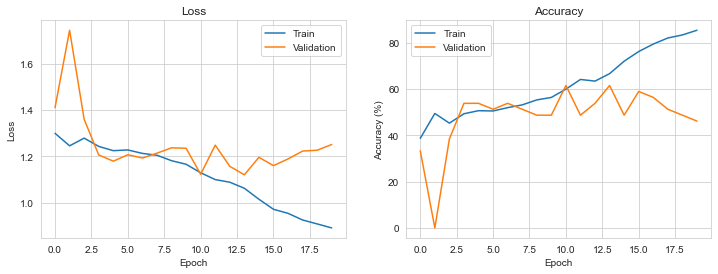

In [27]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

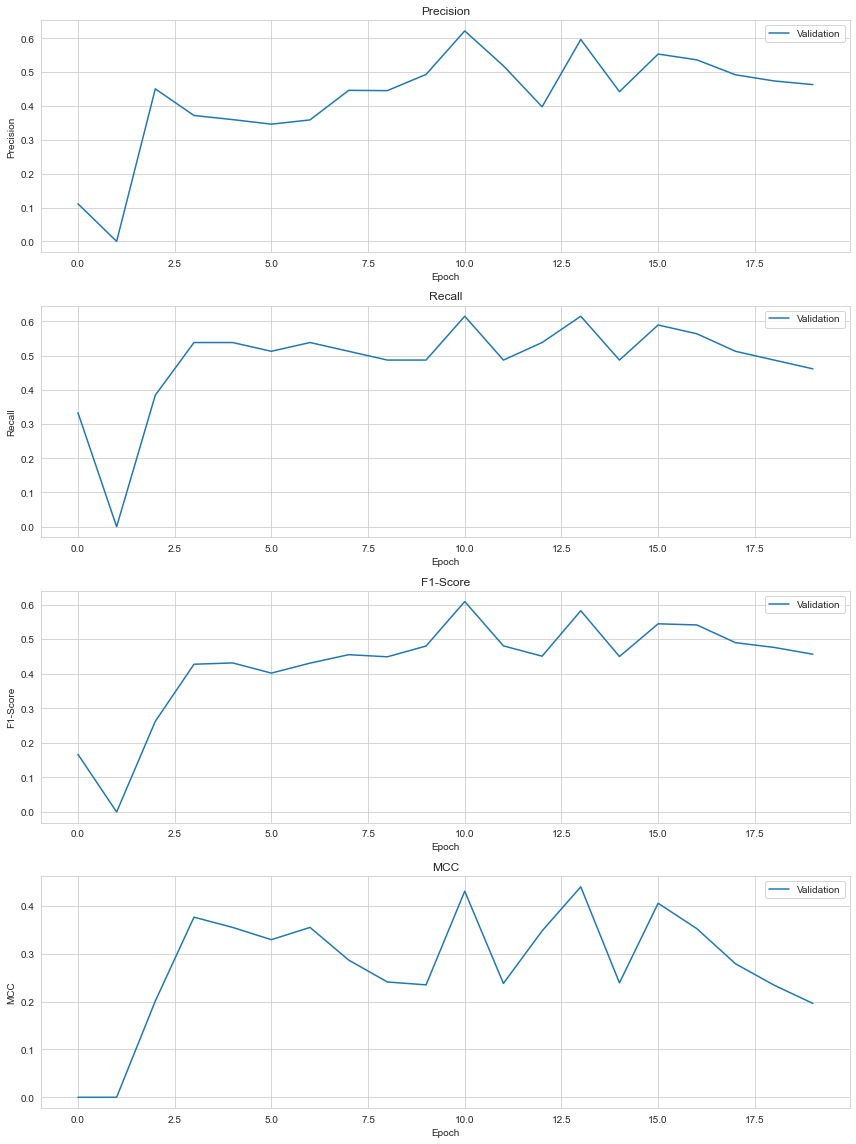

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Precision
ax1.plot(val_precisions, label='Validation')
ax1.set_title('Precision')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall
ax2.plot(val_recalls, label='Validation')
ax2.set_title('Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall')
ax2.legend()

# F1-score
ax3.plot(val_f1_scores, label='Validation')
ax3.set_title('F1-Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()

# MCC
ax4.plot(val_mccs, label='Validation')
ax4.set_title('MCC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MCC')
ax4.legend()

plt.tight_layout()
plt.show()


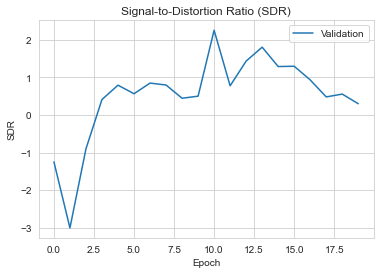

In [31]:
# Convert list of tensors to list of numpy arrays (if necessary)
if isinstance(val_sdrs[0], torch.Tensor):
    val_sdrs_np = [sdr.cpu().numpy() for sdr in val_sdrs]
else:
    val_sdrs_np = val_sdrs

# Plotting SDR
fig, ax = plt.subplots(figsize=(6, 4))

# SDR
ax.plot(val_sdrs_np, label='Validation')
ax.set_title('Signal-to-Distortion Ratio (SDR)')
ax.set_xlabel('Epoch')
ax.set_ylabel('SDR')
ax.legend()

plt.show()


/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


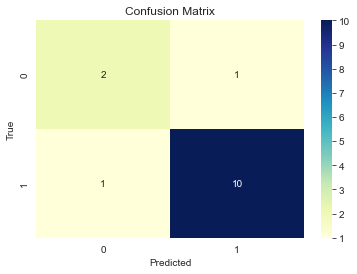

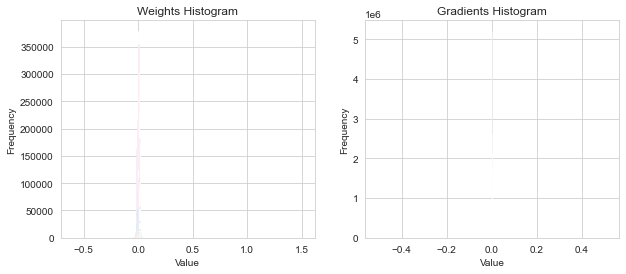

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [33]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [35]:
# # this part doesn't work any more because of the change in the model -> "attention" layer
# # Show model summary
# try:
#     from torchsummary import summary
#     print("\nModel summary:")
#
#     original_device = device
#     if device == 'mps': # because MPS is not supported by torchsummary
#         device = 'cpu'
#
#
#     class ModelWrapper(nn.Module):
#         def __init__(self, module):
#             super(ModelWrapper, self).__init__()
#             self.module = module
#
#         def forward(self, x):
#             return self.module(x)
#
#     model = ModelWrapper(CNNModel(mfcc_dim=32, output_ch=4)).to(device)
#     summary(model, input_size=(1, 32, 112))
#
#     if original_device == 'mps': # Restore original device
#         device = original_device
#         model.to(device)
#
# except ImportError:
#     print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")